In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<h3><b>Getting Ready</b></h3>

In [2]:
# Import libraries
import os
import sys
import random
from pathlib import Path
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo
import torchvision
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from torchmetrics import Accuracy
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
from torchinfo import summary
from tqdm.notebook import tqdm
from tqdm.version import __version__ as tqdm__version__

torch.backends.cudnn.deterministic = True

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device.")

Using cpu device.


In [3]:
# Print out version numbers of libraries
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("matplotlib version : ", matplotlib.__version__)
print("numpy version : ", np.__version__)
print("torch version : ", torch.__version__)
print("torchinfo version : ", torchinfo.__version__)
print("torchvision version : ", torchvision.__version__)
print("PIL version : ", PIL.__version__)
print("scikit-learn version: ", sklearn.__version__)
print("tqdm version: ", tqdm__version__)

Platform: linux
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
---
matplotlib version :  3.7.2
numpy version :  1.26.4
torch version :  2.6.0+cu124
torchinfo version :  1.8.0
torchvision version :  0.21.0+cu124
PIL version :  11.3.0
scikit-learn version:  1.2.2
tqdm version:  4.67.1


In [4]:
# Create path to the dataset
BASE_PATH = Path('/kaggle/input/brain-mri-images-for-brain-tumor-detection')

if (BASE_PATH / 'brain_tumor_dataset').exists():
    data_dir = BASE_PATH / 'brain_tumor_dataset'
else:
    data_dir = BASE_PATH

print('Using data directory:', data_dir)
print('Subfolders:', os.listdir(data_dir))

Using data directory: /kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset
Subfolders: ['no', 'yes']


<h3><b>Preparing Our Data</b></h3>

In [5]:
# Set image and batch size
IMAGE_SIZE = 150
BATCH_SIZE = 32

# Create separate transformations for train and test dataset
train_transform = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(12),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]
)

# Load dataset
full_dataset = datasets.ImageFolder(root=str(data_dir), transform=train_transform)
print('Classes found by ImageFolder:', full_dataset.classes)

Classes found by ImageFolder: ['no', 'yes']


In [6]:
# Split data into training and test set
train_size = int(0.80*len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Build test dataset using the same samples but with the test_transform transformations
if isinstance(test_dataset, Subset):
    test_indices = test_dataset.indices
    # original dataset's samples and class_to_idx
    base_dataset = datasets.ImageFolder(root=str(data_dir), transform=test_transform)
    test_dataset = Subset(base_dataset, test_indices)

# Create DataLoaders for training and test set
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Check length of training and test set
print('Train samples:', len(train_dataset), '\nTest samples:', len(test_dataset))

Train samples: 202 
Test samples: 51


In [7]:
# Create a function that counts the class per dataset
def class_count(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

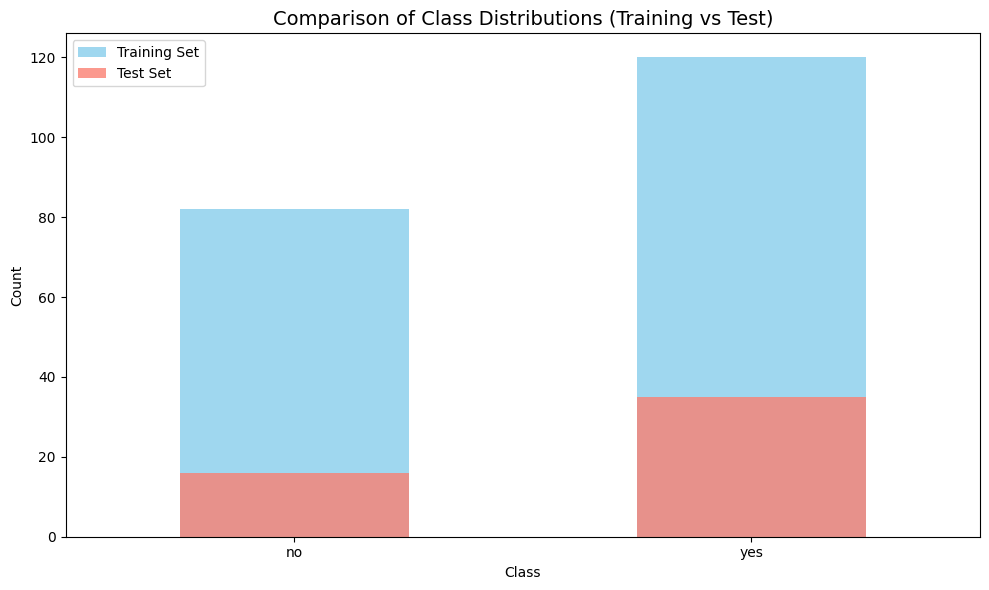

In [8]:
# Plot the class distribution in a single figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the training set
train_class_distributions = class_count(train_dataset).sort_values()
train_class_distributions.plot(
    kind = 'bar',
    ax = ax,
    color = 'skyblue',
    alpha = 0.8,
    label = 'Training Set'
)

# Plot the test set
test_class_distributions = class_count(test_dataset).sort_values()
test_class_distributions.plot(
    kind = 'bar',
    ax = ax,
    color = 'salmon',
    alpha = 0.8,
    label = 'Test Set'
)

# Set common title and add the legend
ax.set_title('Comparison of Class Distributions (Training vs Test)', fontsize=14)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.tick_params(axis='x', labelrotation=0)
ax.legend()
plt.tight_layout()
plt.show();

In [9]:
# Check the shape of a single batch
single_batch = next(iter(train_loader))[0]
print(f"Shape of on training dataset batch: {single_batch.shape}")

Shape of on training dataset batch: torch.Size([32, 3, 150, 150])


<h3><b>Building Our Convolutional Neural Network Model</b></h3>

In [13]:
# Build model
class TumorCNN(nn.Module):
    def __init__(self, input_size=(3, IMAGE_SIZE, IMAGE_SIZE)):
        super().__init__()

        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=16)
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)
        self.flatten = nn.Flatten()

        # Compute flatten size
        self.flatten_dim = self._get_flatten_dim(input_size)

        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.fc2 = nn.Linear(128, 1)
    
    # Apply kaiming initialization
        self._init_weights()

    
    def _init_weights(self):
        """Apply Kaiming initialization to conv, linear, and batchnorm layers."""

        # Loop every module (layer) inside the model
        for m in self.modules():
            # Initialization for Conv2d layers
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu") # relu is used since elu behaves similarly for variance scaling
                
                # If bias exists, a good practice is to set to zero
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            # Initialization for Linear layers
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            # Initialization for BatchNorm layers
            if isinstance(m, nn.BatchNorm2d):
                # BatchNorm gamma weights start at 1 (no scaling)
                nn.init.constant_(m.weight, 1)

                # BatchNorm beta bias starts at 0 (no shift)
                nn.init.constant_(m.bias, 0)

    
    def _get_flatten_dim(self, input_size):
        """Pass a dummy image through conv layers to determine final tensor size.
        """
        with torch.no_grad():
            x = torch.zeros(1, *input_size)
            x = self.pool(self.bn1(F.elu(self.conv1(x))))
            x = self.pool(self.bn2(F.elu(self.conv2(x))))
            x = self.pool(self.bn3(F.elu(self.conv3(x))))
            x = self.flatten(x)
        return x.shape[1]

    
    def forward(self, x):
        x = self.pool(self.bn1(F.elu(self.conv1(x))))
        x = self.pool(self.bn2(F.elu(self.conv2(x))))
        x = self.pool(self.bn3(F.elu(self.conv3(x))))

        x = self.flatten(x)
        x = self.dropout(x)
        x = F.elu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        
        return x

In [14]:
# Instantiate model
model =TumorCNN().to(device)
summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
TumorCNN                                 [32, 1]                   --
├─Conv2d: 1-1                            [32, 16, 150, 150]        448
├─BatchNorm2d: 1-2                       [32, 16, 150, 150]        32
├─MaxPool2d: 1-3                         [32, 16, 75, 75]          --
├─Conv2d: 1-4                            [32, 32, 75, 75]          4,640
├─BatchNorm2d: 1-5                       [32, 32, 75, 75]          64
├─MaxPool2d: 1-6                         [32, 32, 37, 37]          --
├─Conv2d: 1-7                            [32, 64, 37, 37]          18,496
├─BatchNorm2d: 1-8                       [32, 64, 37, 37]          128
├─MaxPool2d: 1-9                         [32, 64, 18, 18]          --
├─Flatten: 1-10                          [32, 20736]               --
├─Dropout: 1-11                          [32, 20736]               --
├─Linear: 1-12                           [32, 128]                 2,654,336

<h3><b>Training Our Model</b></h3>

In [15]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create a training and evaluation function
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = (outputs >= 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# We will use the Accuracy from torchmetrics to compute accuracy in the evaluation stage of the model
acc_metric = Accuracy(task="binary").to(device)

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0
    acc_metric.reset()
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images = images.to(device)
            labels = labels.float().view(-1, 1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            
            preds = (outputs >= 0.5).float()
            acc_metric.update(preds, labels)
    
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = acc_metric.compute().item()
    return epoch_loss, epoch_acc

# Create a confusion matrix / report function
def compute_confusion_and_report(model, loader, display_cm=False):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Computing...", leave=False):
            images = images.to(device)
            outputs = model(images)
            preds = (outputs >= 0.5).long().cpu().numpy().reshape(-1)
            y_pred.extend(preds.tolist())
            y_true.extend(labels.numpy().tolist())

    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4)
    # Display the confusion matrix
    if display_cm == True:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)
        disp.plot(cmap=plt.cm.Blues, xticks_rotation="horizontal")
        plt.show;
    
    return cm, report

In [19]:
# Training loop
EPOCHS = 15
best_val_acc = 0.0
save_path = '/kaggle/working/tumor_cnn.pth'

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    print(f"Epoch {epoch}/{EPOCHS} - Train loss: {train_loss:.4f} Accuracy: {train_acc:.4f} | Validation loss: {val_loss:.4f} Accuracy: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print('Saved best model to', save_path)

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/15 - Train loss: 0.5299 Accuracy: 0.7723 | Validation loss: 2.5175 Accuracy: 0.7843
Saved best model to /kaggle/working/tumor_cnn.pth


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2/15 - Train loss: 0.4641 Accuracy: 0.8119 | Validation loss: 2.8306 Accuracy: 0.7843


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3/15 - Train loss: 0.4736 Accuracy: 0.8069 | Validation loss: 2.6765 Accuracy: 0.7451


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4/15 - Train loss: 0.5233 Accuracy: 0.8020 | Validation loss: 2.3861 Accuracy: 0.8039
Saved best model to /kaggle/working/tumor_cnn.pth


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5/15 - Train loss: 0.4473 Accuracy: 0.8069 | Validation loss: 2.5067 Accuracy: 0.8039


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6/15 - Train loss: 0.4247 Accuracy: 0.8564 | Validation loss: 2.4440 Accuracy: 0.8039


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7/15 - Train loss: 0.4047 Accuracy: 0.8515 | Validation loss: 0.9562 Accuracy: 0.8039


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8/15 - Train loss: 0.3432 Accuracy: 0.8564 | Validation loss: 0.6897 Accuracy: 0.9020
Saved best model to /kaggle/working/tumor_cnn.pth


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9/15 - Train loss: 0.3661 Accuracy: 0.8564 | Validation loss: 2.4766 Accuracy: 0.8235


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10/15 - Train loss: 0.4158 Accuracy: 0.8366 | Validation loss: 2.3720 Accuracy: 0.8627


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11/15 - Train loss: 0.3943 Accuracy: 0.8267 | Validation loss: 2.2592 Accuracy: 0.8627


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12/15 - Train loss: 0.2425 Accuracy: 0.8911 | Validation loss: 2.3134 Accuracy: 0.8824


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13/15 - Train loss: 0.2589 Accuracy: 0.8614 | Validation loss: 2.4567 Accuracy: 0.8235


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14/15 - Train loss: 0.3434 Accuracy: 0.8564 | Validation loss: 2.3532 Accuracy: 0.8824


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15/15 - Train loss: 0.2203 Accuracy: 0.9158 | Validation loss: 2.4778 Accuracy: 0.8431


Computing...:   0%|          | 0/2 [00:00<?, ?it/s]

Confusion Matrix:
 [[14  2]
 [ 3 32]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8235    0.8750    0.8485        16
           1     0.9412    0.9143    0.9275        35

    accuracy                         0.9020        51
   macro avg     0.8824    0.8946    0.8880        51
weighted avg     0.9043    0.9020    0.9027        51



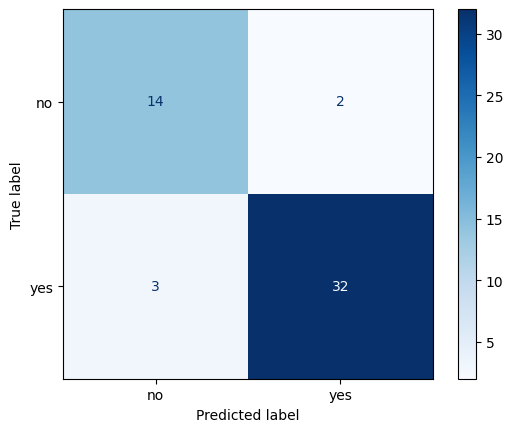

In [20]:
# Final evaluation
model.load_state_dict(torch.load(save_path))
cm, report = compute_confusion_and_report(model, test_loader, display_cm=True)
print('Confusion Matrix:\n', cm)
print('\nClassification Report:\n', report)

In [21]:
# Quick inference helper
from PIL import Image

def predict_image(model, img_path, transform=test_transform):
    model.eval()
    img = Image.open(img_path).convert('RGB')
    x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(x)
        prob = float(out.item())
        label = 1 if prob >= 0.5 else 0
    return label, prob

In [24]:
# Test inference helper

img_path1 = "/kaggle/input/test-images/Tumor_no.jpg" # No tumor image
img_path2 = "/kaggle/input/test-images/Tumor_yes.jpg" # Yes tumor image

model.load_state_dict(torch.load(save_path))

label1, prob1 = predict_image(model=model, img_path=img_path1)
label2, prob2 = predict_image(model=model, img_path=img_path2)

# Print results
print(f"Prediction on Image without Tumor:\nLabel: {label1} | Probability: {prob1}")
print(f"\nPrediction on Image with Tumor:\nLabel: {label2} | Probability: {prob2}")

Prediction on Image without Tumor:
Label: 0 | Probability: 0.00029747223015874624

Prediction on Image with Tumor:
Label: 0 | Probability: 0.46866822242736816
